In this notebook, we cover multi-output GPs. The presentation follows the [excellent video from GPSS](https://www.youtube.com/watch?v=ttgUJtVJthA)

In [1]:
import numpy as np
from scipy.stats import multivariate_normal
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib
#matplotlib.rcParams['figure.figsize'] = (8,6)
from matplotlib import pyplot as plt
import GPy

# ICM 

$u \sim GP (0, k)$

sample from u to get a sample $u^1$

$f_1(x) = a^1_1 u^1(x)$

$f_2(x) = a^1_2 u^1(x)$

In [2]:
X = np.linspace(-3.,3., 50)

In [3]:
kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=2.)

In [4]:
kernel

rbf.,value,constraints,priors
variance,1.0,+ve,
lengthscale,2.0,+ve,


In [5]:
def jitter(C,  j = 1e-6):
    return C + np.eye(len(C))*j

In [6]:
cov = jitter(kernel.K(X.reshape(-1, 1)))

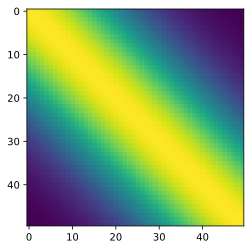

In [7]:
plt.imshow(cov)

In [8]:
mvn = multivariate_normal(cov=cov)

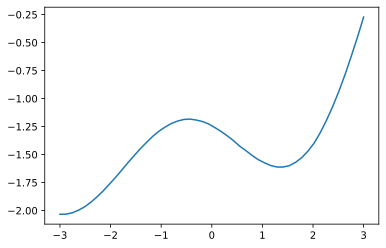

In [9]:
u1 = mvn.rvs(random_state=0)
plt.plot(X, u1)

In [10]:
a11 = 0.9
a12 = 0.7

a = np.array([a11, a12]).reshape(-1, 1)

In [11]:
a

array([[0.9],
       [0.7]])

In [12]:
B = a@a.T
B

array([[0.81, 0.63],
       [0.63, 0.49]])

In [13]:
cov_f = np.kron(B, cov)

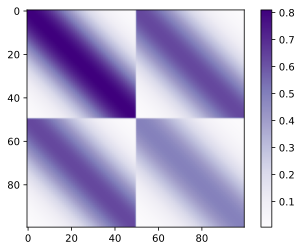

In [14]:
plt.imshow(cov_f, cmap='Purples')
plt.colorbar()

In [15]:
f_sample = multivariate_normal(cov=jitter(cov_f)).rvs(size=500)
f1_samples, f2_samples = f_sample[:, :50], f_sample[:, 50:]

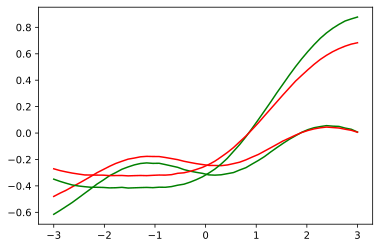

In [16]:
#plt.plot(X, u1, label="u1")
for i in range(2):
    plt.plot(X, f1_samples[i], color='g') 
    plt.plot(X, f2_samples[i], color='r' )


In [17]:
f1_samples[i]/f2_samples[i]

array([1.29001747, 1.28782231, 1.29213179, 1.29655859, 1.2910596 ,
       1.28022287, 1.29141646, 1.28932974, 1.29187867, 1.28777197,
       1.28696956, 1.27942803, 1.28431391, 1.2854025 , 1.28507594,
       1.27639392, 1.29202709, 1.28970373, 1.28891419, 1.28651975,
       1.29556292, 1.2868888 , 1.28225567, 1.28034175, 1.27515627,
       1.27373518, 1.28054148, 1.29750681, 1.29754529, 1.26400689,
       1.31913689, 1.24073838, 1.33827399, 1.31713532, 1.28637457,
       1.28295872, 1.28976821, 1.28136814, 1.28429299, 1.27849431,
       1.28724655, 1.2875927 , 1.28644187, 1.28685871, 1.28775697,
       1.28732514, 1.28801596, 1.28961128, 1.28341466, 1.28447937])

In [18]:
## Learning in MOGP setting

f1_dataset = f1_samples[4]
f2_dataset  = f2_samples[4]

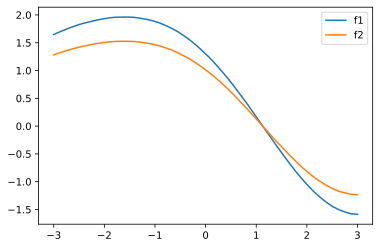

In [19]:
plt.plot(X, f1_dataset, label='f1')
plt.plot(X, f2_dataset, label='f2')
plt.legend()

In [20]:
## What all we want to learn:

# 1. GP kernel parameters
# 2. a11, a12

In [21]:
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)
import tensorflow_probability.substrates.jax as tfp

In [22]:
f = jnp.hstack([f1_dataset, f2_dataset])

In [23]:
def sqexp(a, b, var=1.0, ls=4):
    diff = (a-b)/ls
    d = jnp.sum(diff ** 2)
    return var*jnp.exp(-0.5 * d)

def all_pairs(f):
    f = jax.vmap(f, in_axes= (None, 0, None, None))
    f = jax. vmap (f, in_axes= (0, None, None, None))
    return f

In [24]:
kernel.K(X.reshape(-1, 1))

array([[1.        , 0.99812754, 0.99253116, ..., 0.01592046, 0.01332383,
        0.011109  ],
       [0.99812754, 1.        , 0.99812754, ..., 0.01895197, 0.01592046,
        0.01332383],
       [0.99253116, 0.99812754, 1.        , ..., 0.02247631, 0.01895197,
        0.01592046],
       ...,
       [0.01592046, 0.01895197, 0.02247631, ..., 1.        , 0.99812754,
        0.99253116],
       [0.01332383, 0.01592046, 0.01895197, ..., 0.99812754, 1.        ,
        0.99812754],
       [0.011109  , 0.01332383, 0.01592046, ..., 0.99253116, 0.99812754,
        1.        ]])

In [25]:
np.allclose(np.array(all_pairs(sqexp)(X, X, 1.0, 2.0)), kernel.K(X.reshape(-1, 1)))

True

In [33]:
def covariance_f(var, ls, a11, a12):
    a = jnp.array([[a11], [a12]])
    B = a@a.T
    cov = all_pairs(sqexp)(X, X, var, ls)
    cov_f = jitter(jnp.kron(B, cov))
    return cov_f

In [34]:
def cost(var, ls, a11, a12):
    cov_f = covariance_f(var, ls, a11, a12)
    dist = tfp.distributions.MultivariateNormalFullCovariance(loc = jnp.zeros_like(f), covariance_matrix = cov_f)
    return -dist.log_prob(f)

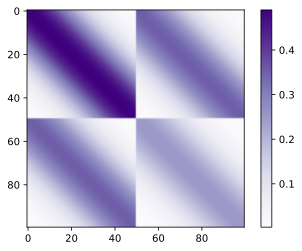

In [35]:
plt.imshow(covariance_f(1.0, 2.0, 0.7, 0.5), cmap='Purples')
plt.colorbar()

In [36]:
cost(1.0, 2.0, 0.5, 0.5)

DeviceArray(1322646.27797538, dtype=float64)

In [37]:
cost(1.0, 1.0, 0.9, 0.7)

DeviceArray(-440.03175204, dtype=float64)

In [38]:
jax.grad(cost, argnums=[0, 1, 2, 3])(0.1, 10.0, 0.9, 1.0)

(DeviceArray(-773126.94591331, dtype=float64, weak_type=True),
 DeviceArray(60562.85097156, dtype=float64, weak_type=True),
 DeviceArray(-16499085.08959961, dtype=float64, weak_type=True),
 DeviceArray(14694551.19384766, dtype=float64, weak_type=True))

In [39]:
jnp.linalg.cholesky(covariance_f(1.0, 2.0, 0.7, 0.5))

DeviceArray([[7.00000714e-01, 0.00000000e+00, 0.00000000e+00, ...,
              0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
             [6.98688562e-01, 4.28403175e-02, 0.00000000e+00, ...,
              0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
             [6.94771100e-01, 8.52904956e-02, 4.43287874e-03, ...,
              0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
             ...,
             [7.96022400e-03, 2.50108071e-02, 4.57917095e-02, ...,
              1.04755709e-03, 0.00000000e+00, 0.00000000e+00],
             [6.66191065e-03, 2.14181818e-02, 4.01360061e-02, ...,
              8.98255573e-05, 1.06177828e-03, 0.00000000e+00],
             [5.55449260e-03, 1.82650786e-02, 3.50165118e-02, ...,
              6.35832454e-05, 1.65693669e-04, 1.15361156e-03]],            dtype=float64)

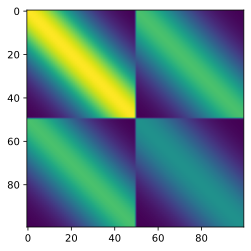

In [41]:
c = covariance_f(1.0, 2.0, 0.7, 0.5)
plt.imshow(c)

In [47]:
ss = tfp.distributions.MultivariateNormalFullCovariance(covariance_matrix=c).sample(sample_shape=(20, ), seed=jax.random.PRNGKey(0))

In [48]:
ss.shape

(20, 100)

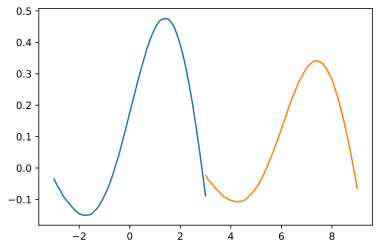

In [55]:
plt.plot(X, ss[0, :50])
plt.plot(X+(X.max()-X.min()), ss[0, 50:])